In [1]:
#mixture of ideas and code from the following sources:
#https://github.com/DebarghaG/Tansen/blob/master/train_network.py#L22
#https://medium.com/@leesurkis/how-to-generate-techno-music-using-deep-learning-17c06910e1b3

#most similar to this implementation:
#https://hedonistrh.github.io/2018-04-27-Music-Generation-with-LSTM/

#for parsing music
import music21
import os
import pickle
import numpy as np

#for visualisation
import pydot

#DL imports
from keras import layers, models, Input
from keras.models import Model
import keras
import tensorflow as tf
from keras.layers.advanced_activations import *

#for sampling
import random
import sys, inspect

#global variables; see below for actual hyperparam global vars

#redundant
#all_notes = {}
#all_durations = {}
#all_offsets = {}

####################    HELPER FUNCTIONS    ###########################

#from https://github.com/hedonistrh/bestekar/blob/master/LSTM_colab.ipynb
def check_float(duration): # This function fix the issue which comes from some note's duration. 
                           # For instance some note has duration like 14/3 or 7/3. 
    if ('/' in duration):
        numerator = float(duration.split('/')[0])
        denominator = float(duration.split('/')[1])
        duration = str(float(numerator/denominator))
    return duration

#from https://github.com/hedonistrh/bestekar/blob/master/LSTM_colab.ipynb
def note_to_int(note): # converts the note's letter to pitch value which is integer form.
    # source: https://musescore.org/en/plugin-development/note-pitch-values
    # idea: https://github.com/bspaans/python-mingus/blob/master/mingus/core/notes.py
    
    note_base_name = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    if ('#-' in note):
        first_letter = note[0]
        base_value = note_base_name.index(first_letter)
        octave = note[3]
        value = base_value + 12*(int(octave)-(-1))
        
    elif ('#' in note): 
        first_letter = note[0]
        base_value = note_base_name.index(first_letter)
        octave = note[2]
        value = base_value + 12*(int(octave)-(-1))
        
    elif ('-' in note): 
        first_letter = note[0]
        base_value = note_base_name.index(first_letter)
        octave = note[2]
        value = base_value + 12*(int(octave)-(-1))
        
    else:
        first_letter = note[0]
        base_val = note_base_name.index(first_letter)
        octave = note[1]
        value = base_val + 12*(int(octave)-(-1))
        
    return value


#function from https://github.com/hedonistrh/bestekar/blob/master/LSTM_colab.ipynb generalised to extract the chords, notes and offsets of any instrument for given midi file
def extract_instrument_features(instrument_index, parts):
    notes_to_parse = parts.parts[instrument_index].recurse()
    duration_instrument = float(check_float((str(notes_to_parse._getDuration()).split(' ')[-1])[:-1]))
            
    durations = []
    notes = []
    offsets = []
            
    for element in notes_to_parse:
        if isinstance(element, music21.note.Note): # If it is single note
            notes.append(note_to_int(str(element.pitch))) # Append note's integer value to "notes" list.
            duration = str(element.duration)[27:-1] 
            durations.append(check_float(duration)) 
            offsets.append(element.offset)

        elif isinstance(element, music21.chord.Chord): # If it is chord
            notes.append('.'.join(str(note_to_int(str(n)))
                                    for n in element.pitches))
            duration = str(element.duration)[27:-1]
            durations.append(check_float(duration))
            offsets.append(element.offset)
                    
    return durations, notes, offsets
    
def check_float(duration): # This function fix the issue which comes from some note's duration. 
                           # For instance some note has duration like 14/3 or 7/3. 
    if ('/' in duration):
        numerator = float(duration.split('/')[0])
        denominator = float(duration.split('/')[1])
        duration = str(float(numerator/denominator))
    return duration


#postprocessing sampler for generated audio
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    num_of_top = 15
    num_of_first = np.random.randint(1,3)

    
    preds [0:48] = 0 # eliminate notes with low octaves
    preds [100:] = 0 # eliminate notes with very high octaves
    
    ind = np.argpartition(preds, -1*num_of_top)[-1*num_of_top:]
    top_indices_sorted = ind[np.argsort(preds[ind])]
    
    
    array = np.random.uniform(0.0, 0.0, (128)) 
    array[top_indices_sorted[0:num_of_first]] = 1.0
    array[top_indices_sorted[num_of_first:num_of_first+3]] = 0.5

    return array

Using TensorFlow backend.


In [2]:
#THIS FUNCTION DEALS WITH HOW THE EXTRACTED FEATURES ARE CONVERTED INTO THE INPUT VECTOR FOR THE RNN

#TAKEN FROM: https://github.com/hedonistrh/bestekar/blob/master/LSTM_colab.ipynb

# Lets determine our matrix's value 
# rest --> (min_value, lower_bound)
# continuation --> (lower_bound, upper_bound)
# first_touch --> (upper_bound, max_value)

min_value = 0.00
lower_first = 0.00

lower_second = 0.5
upper_first = 0.5

upper_second = 1.0
max_value = 1.0

#taken from https://github.com/hedonistrh/bestekar/blob/master/LSTM_colab.ipynb
def notes_to_matrix(notes, durations, offsets, min_value=min_value, lower_first=lower_first,
                    lower_second=lower_second,
                    upper_first=upper_first, upper_second=upper_second,
                    max_value=max_value):
    
    # I want to represent my notes in matrix form. X axis will represent time, Y axis will represent pitch values.
    # I should normalize my matrix between 0 and 1.
    # So that I will represent rest with (min_value, lower_first), continuation with [lower_second, upper_first]
    # and first touch with (upper_second, max_value)
    # First touch means that you press the note and it cause to 1 time duration playing. Continuation
    # represent the continuum of this note playing. 
    
    try:
        last_offset = int(offsets[-1]) 
    except IndexError:
        print ('Index Error')
        return (None, None, None)
    
    total_offset_axis = last_offset * 4 + (8 * 4) 
    our_matrix = np.random.uniform(min_value, lower_first, (128, int(total_offset_axis))) 
    # creates matrix and fills with (-1, -0.3), this values will represent the rest.
    
    for (note, duration, offset) in zip(notes, durations, offsets):
        how_many = int(float(duration)/0.25) # indicates time duration for single note.
       
        
        # Define difference between single and double note.
        # I have choose the value for first touch, the another value for continuation.
        # Lets make it randomize
        
        # I choose to use uniform distrubition. Maybe, you can use another distrubition like Gaussian.
        # I will try 
        first_touch = np.random.uniform(upper_second, max_value, 1)
        continuation = np.random.uniform(lower_second, upper_first, 1)
        
        if ('.' not in str(note)): # It is not chord. Single note.
            our_matrix[note, int(offset * 4)] = first_touch
            our_matrix[note, int((offset * 4) + 1) : int((offset * 4) + how_many)] = continuation

        else: # For chord
            chord_notes_str = [note for note in note.split('.')] 
            chord_notes_float = list(map(int, chord_notes_str)) # Take notes in chord one by one

            for chord_note_float in chord_notes_float:
                our_matrix[chord_note_float, int(offset * 4)] = first_touch
                our_matrix[chord_note_float, int((offset * 4) + 1) : int((offset * 4) + how_many)] = continuation
                
    return our_matrix

In [3]:
#ITERATE THROUGH ALL MIDI FILES IN /data DIR AND CONVERT THEM INTO MATRICES OF UNIFORM SHAPE TO FEED INTO RNN

def parse_music_dominant_instrument(directory = 'data', length = 250):
    
    input_matrices = []
    
    for file in os.listdir(directory):
        
        print('\n')
        print('parsing ' + file + '...')
        midi_file = music21.converter.parse(directory + '/' + file)
        
        notes_to_parse = None
        
        #partition by instrument
        parts = music21.instrument.partitionByInstrument(midi_file)
        
        instrument_names = []
        
        try:
            for instrument in parts: # Learn names of instruments.
                name = (str(instrument).split(' ')[-1])[:-1]
                instrument_names.append(name)
            print('Instruments in ' + file + ':')
            print(instrument_names)

        except TypeError:
            print ('Type is not iterable for ' + file)
            continue #can't iterate over instruments for this midi file; go to next file
        
        #identify and extract the features of the most dominant instrument
        dominant_instrument_name = ''
        max_durations_len, max_notes_len, max_offsets_len = 0
        for instrument_name in instrument_names:
            
            instrument_index = instrument_names.index(instrument_name)
            instrument_durations, instrument_notes, instrument_offsets = extract_instrument_features(instrument_index, parts)
            if len(instrument_durations) > max_durations_len and len(instrument_notes) > max_notes_len and len(instrument_offsets) > max_offsets_len:
                dominant_instrument_name = instrument_name
                dominant_instrument_durations = instrument_durations
                dominant_instrument_notes = instrument_notes
                dominant_instrument_offsets = instrument_offsets
        
        #redundant
        #all_durations[file] = instrument_durations
        #all_notes[file] = instrument_notes
        #all_offsets[file] = instrument_offsets
        
        print('The Dominant instrument of ' + file + ' is :' + dominant_instrument_name)
        print('Instrument Durations Length: ' + str(len(dominant_instrument_durations)))
        print('Instrument Notes Length: ' + str(len(dominant_instrument_notes)))
        print('Instrument Offsets Length: ' + str(len(dominant_instrument_offsets)))
        
        '''
        print('Instrument Durations: ')
        print(instrument_durations)
        print('Instrument Notes: ')
        print(instrument_notes)
        print('Instrument Offsets: ')
        print(instrument_offsets)
        '''
        
        our_matrix = notes_to_matrix(dominant_instrument_notes, dominant_instrument_durations, dominant_instrument_offsets)
    
        try:
            freq, time = our_matrix.shape
        except AttributeError:
            print("'tuple' object has no attribute 'shape'. Trouble converting notes to matrix and moving to next file.")
            continue

        if (time >= length):
            input_matrices.append(our_matrix[:,:length]) # We have to set all individual note matrix to same shape for Generative DL.
        else:
            print(file + ' is not of long enough duration to be used as a part of the training set.')
    
    return input_matrices



In [4]:
#ITERATE THROUGH ALL MIDI FILES IN /data DIR AND CONVERT THEM INTO MATRICES OF UNIFORM SHAPE TO FEED INTO RNN

def parse_music_all_instruments(directory = 'data', length = 250, min_significance = 5):
    
    input_matrices = []
    
    for file in os.listdir(directory):
        
        print('\n')
        print('parsing ' + file + '...')
        midi_file = music21.converter.parse(directory + '/' + file)
        
        notes_to_parse = None
        
        #partition by instrument
        parts = music21.instrument.partitionByInstrument(midi_file)
        
        instrument_names = []
        
        try:
            for instrument in parts: # Learn names of instruments.
                name = (str(instrument).split(' ')[-1])[:-1]
                instrument_names.append(name)
            print('Instruments in ' + file + ':')
            print(instrument_names)

        except TypeError:
            print ('Type is not iterable for ' + file)
            continue #can't iterate over instruments for this midi file; go to next file
        
        #identify and extract the features of the most dominant instrument
        dominant_instrument_name = ''
        for instrument_name in instrument_names:
            dominant_instrument_name = instrument_name
            instrument_index = instrument_names.index(instrument_name)
            instrument_durations, instrument_notes, instrument_offsets = extract_instrument_features(instrument_index, parts)
            
            if len(instrument_durations)>=min_significance and len(instrument_notes)>=min_significance and len(instrument_offsets)>=min_significance:
            #if len(instrument_durations) and len(instrument_notes) and len(instrument_offsets):
                
                print('The next found instrument of ' + file + ' is :' + dominant_instrument_name)
                print('Instrument Durations Length: ' + str(len(instrument_durations)))
                print('Instrument Notes Length: ' + str(len(instrument_notes)))
                print('Instrument Offsets Length: ' + str(len(instrument_offsets)))
        
                our_matrix = notes_to_matrix(instrument_notes, instrument_durations, instrument_offsets)
    
                try:
                    freq, time = our_matrix.shape
                except AttributeError:
                    print("'tuple' object has no attribute 'shape'. Trouble converting notes to matrix and moving to next instrument of this file.")
                    continue

                if (time >= length):
                    input_matrices.append(our_matrix[:,:length]) # We have to set all individual note matrix to same shape for Generative DL.
                else:
                    print(dominant_instrument_name + ' is not of long enough duration to be used as a part of the training set.')
    
    return input_matrices



In [5]:
#creates the actual input and real output X and Y to be passed to Keras's model.fit(X,y) from the parsed matrices created by parse_music()
#X is just the notes inscribed with the durations+offsets; Y is the same, but the future predictions stepped to the right by 'step'
#max_len is the number of X time lengths used to predict a given Y
#max_len and step are hyperparams; can use for tuning later
#wrapped into a function using code from https://github.com/hedonistrh/bestekar/blob/master/LSTM_colab.ipynb

def create_training_data(input_matrices, max_len = 15, step = 1):
    
    midis_array = np.asarray(input_matrices)
    midis_array_raw = midis_array
    
    
    # Midis array shape --> (# of file, # of frx.eq, # of time in a single file)
    # Firtly, I will convert to (# of file, # of time in a single file, # of freq,)
    midis_array = np.transpose(midis_array_raw, (0, 2, 1)) 
    midis_array = np.asarray(midis_array)
    
    # Secondly, convert to (# of freq, # of file * # of time in a single file)
    midis_array = np.reshape(midis_array,(-1,128))
    
    X = []
    Y = []

    for i in range (0, midis_array.shape[0]-max_len, step):
        prev = midis_array[i:i+max_len,...] # take max_len column.
        pred = midis_array[i+max_len,...] # take (max_len)th column.
        X.append(prev)
        Y.append(pred)
    
    #convert lists to np arrays
    X = np.asarray(X).astype('float64')
    Y = np.asarray(Y).astype('float64')
    
    return X,Y, midis_array

In [6]:
#Reverse funcs to convert sampled matrices data back into midi format

def int_to_note(integer):
    # Convert pitch value to the note which is a letter form. 
    note_base_name = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    octave_detector = (integer // 12) 
    base_name_detector = (integer % 12) 
    note = note_base_name[base_name_detector] + str((int(octave_detector))-1)
    if ('-' in note):
        note = note_base_name[base_name_detector] + str(0)
        return note
    return note

# PAY ATTENTION. From matrix form to midi form, I have to indicate first touch, continuation and rest with unique numbers.
# I choose -1.0 for rest , 0 for continuation and 1 for first touch.

lower_bound = (lower_first + lower_second) / 2
upper_bound = (upper_first + upper_second) / 2

def converter_func(arr,first_touch = 1.0, continuation = 0.0, lower_bound = lower_bound, upper_bound = upper_bound):
    # I can write this function thanks to https://stackoverflow.com/questions/16343752/numpy-where-function-multiple-conditions
    # First touch represent start for note, continuation represent continuation for first touch, 0 represent end or rest
    np.place(arr, arr < lower_bound, -1.0)
    np.place(arr, (lower_bound <= arr) & (arr < upper_bound), 0.0)
    np.place(arr, arr >= upper_bound, 1.0)
    return arr

def how_many_repetitive_func(array, from_where=0, continuation=0.0):
    new_array = array[from_where:]
    count_repetitive = 1 
    for i in new_array:
        if (i != continuation):
            return (count_repetitive)
        else:
            count_repetitive += 1
    return (count_repetitive)

def matrix_to_midi(matrix, random=0):
    first_touch = 1.0
    continuation = 0.0
    y_axis, x_axis = matrix.shape
    output_notes = []
    offset = 0
        
    # Delete rows until the row which include 'first_touch'
    how_many_in_start_zeros = 0
    for x_axis_num in range(x_axis):
        one_time_interval = matrix[:,x_axis_num] # Values in a column.
        one_time_interval_norm = converter_func(one_time_interval)
        if (first_touch not in one_time_interval_norm):
            how_many_in_start_zeros += 1
        else:
            break
            
    how_many_in_end_zeros = 0
    for x_axis_num in range(x_axis-1,0,-1):
        one_time_interval = matrix[:,x_axis_num] # values in a column
        one_time_interval_norm = converter_func(one_time_interval)
        if (first_touch not in one_time_interval_norm):
            how_many_in_end_zeros += 1
        else:
            break
        
    print ('How many rows for non-start note at beginning:', how_many_in_start_zeros)
    print ('How many rows for non-start note at end:', how_many_in_end_zeros)

    matrix = matrix[:,how_many_in_start_zeros:]
    y_axis, x_axis = matrix.shape
    print (y_axis, x_axis)

    for y_axis_num in range(y_axis):
        one_freq_interval = matrix[y_axis_num,:] # Values in a row.
        
        one_freq_interval_norm = converter_func(one_freq_interval)
        
        i = 0        
        offset = 0
        
        if (random):
          
          while (i < len(one_freq_interval)):
                how_many_repetitive = 0
                temp_i = i
                if (one_freq_interval_norm[i] == first_touch):
                    how_many_repetitive = how_many_repetitive_func(one_freq_interval_norm, from_where=i+1, continuation=continuation)
                    i += how_many_repetitive 

                if (how_many_repetitive > 0):
                    random_num = np.random.randint(3,6)
                    new_note = music21.note.Note(int_to_note(y_axis_num),duration=music21.duration.Duration(0.25*random_num*how_many_repetitive))
                    new_note.offset = 0.25*temp_i*2
                    new_note.storedInstrument = music21.instrument.Piano()
                    output_notes.append(new_note)
                else:
                    i += 1
        
          
        else:
          
          while (i < len(one_freq_interval)):
                how_many_repetitive = 0
                temp_i = i
                if (one_freq_interval_norm[i] == first_touch):
                    how_many_repetitive = how_many_repetitive_func(one_freq_interval_norm, from_where=i+1, continuation=continuation)
                    i += how_many_repetitive 

                if (how_many_repetitive > 0):
                    new_note = music21.note.Note(int_to_note(y_axis_num),duration=music21.duration.Duration(0.25*how_many_repetitive))
                    new_note.offset = 0.25*temp_i
                    new_note.storedInstrument = music21.instrument.Piano()
                    output_notes.append(new_note)
                else:
                    i += 1
        
    return output_notes

def create_samples(name, model, midis_array, output_dir, num_samples, output_len):
    
    for sample_no in range(1, num_samples+1):
        
        start_index = random.randint(0, len(midis_array)- max_len - 1)
        generated_midi = midis_array[start_index: start_index + max_len]
        
        temperature = float(np.random.randint(max_temp))/10
        print('------ temperature:', temperature)
        print('------ Sample No:', sample_no)
        generated_midi = midis_array[start_index: start_index + max_len]
        
        #this just decides the length of the output file samples
        for i in range(output_len):
            samples = generated_midi[i:]
            expanded_samples = np.expand_dims(samples, axis=0)
            preds = model.predict(expanded_samples, verbose=0)[0]
            preds = np.asarray(preds).astype('float64')

            next_array = sample(preds, temperature)
           
            midi_list = []
            midi_list.append(generated_midi)
            midi_list.append(next_array)
            generated_midi = np.vstack(midi_list)
            

        generated_midi_final = np.transpose(generated_midi,(1,0))
        output_notes = matrix_to_midi(generated_midi_final, random=1)
        midi_stream = music21.stream.Stream(output_notes)
        midi_file_name = (output_dir + '/' + name+ '_{}_temp_{}.mid'.format(sample_no, temperature))
        midi_stream.write('midi', fp=midi_file_name)
        parsed = music21.converter.parse(midi_file_name)
        for part in parsed.parts:
            part.insert(0, music21.instrument.Piano())
        parsed.write('midi', fp=midi_file_name)

In [7]:
#POST PROCESSING CUSTOM FUNCTIONS

#limitation for multiple instruments: https://stackoverflow.com/questions/63032999/output-more-than-one-instrument-using-music-21-and-python

def bollywood_postprocess_produced_samples(source_directory, target_directory):
    instruments = [music21.instrument.Sitar(),
                  music21.instrument.Flute(),
                   music21.instrument.Shehnai()]
    
    for file in os.listdir(source_directory):
        
        print('\n')
        print('postprocessing ' + file + '...')
        
        midi_file = music21.converter.parse(source_directory + '/' + file)
        for element in midi_file.recurse():
            if 'Instrument' in element.classes: # or 'Piano'
                rand_instrument_chooser = np.random.randint(1,3)
                element.activeSite.replace(element, instruments[rand_instrument_chooser])

        midi_file.write('midi', target_directory + '/' + file)

In [8]:
#the actual RNN model wrapped into a function. Taken from https://github.com/hedonistrh/bestekar/blob/master/LSTM_colab.ipynb

#v0: original version from https://github.com/hedonistrh/bestekar/blob/master/LSTM_colab.ipynb
#v2: all layers except 

def RNN_model(max_len, no_of_values):
    
    input_midi = keras.Input((max_len, no_of_values))
    
    #LSTM 1 is halved for v3 from 1024 to 512
    x = layers.LSTM(512, return_sequences=True, unit_forget_bias=True)(input_midi)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization() (x)
    x = layers.Dropout(0.3)(x)

    # compute importance/attention for each step
    attention = layers.Dense(1, activation='tanh')(x)
    attention = layers.Flatten()(attention)
    attention = layers.Activation('softmax')(attention)
    #copy layer 1 is halved for v3 from 1024 to 512
    attention = layers.RepeatVector(512)(attention)
    attention = layers.Permute([2, 1])(attention)

    multiplied = layers.Multiply()([x, attention])
    sent_representation = layers.Dense(512)(multiplied)

    #halved from 512 to 256 for v2 and v3
    x = layers.Dense(512)(sent_representation)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization() (x)
    x = layers.Dropout(0.2)(x)

    #halved from 512 to 256 for v2 and v3
    x = layers.LSTM(512, return_sequences=True, unit_forget_bias=True)(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization() (x)
    x = layers.Dropout(0.2)(x)


    # compute importance for each step
    attention = layers.Dense(1, activation='tanh')(x)
    attention = layers.Flatten()(attention)
    attention = layers.Activation('softmax')(attention)
    #halved from 512 to 256 for v2 and v3
    attention = layers.RepeatVector(512)(attention)
    attention = layers.Permute([2, 1])(attention)

    multiplied = layers.Multiply()([x, attention])
    #halved from 256 to 128 for v2 and v3
    sent_representation = layers.Dense(128)(multiplied)

    #halved from 256 to 128 for v2 and v3
    x = layers.Dense(128)(sent_representation)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization() (x)
    x = layers.Dropout(0.22)(x)

    #lowest possible value of 128 for all versions
    x = layers.LSTM(128, unit_forget_bias=True)(x)
    x = layers.LeakyReLU()(x)
    x = layers.BatchNormalization() (x)
    x = layers.Dropout(0.22)(x)

    #lowest possible value of 128 for all versions
    x = layers.Dense(128, activation='softmax')(x) 

    model = Model(inputs = input_midi, outputs = x)
    
    return model

In [9]:
#GLOBAL VAR HYPERPARAMS

#input matrix hyperparam; the min no of notes an instrument must play in a song to be included in the training data
min_significance = 5

max_len = 15
step = 1
no_of_values = 128 #the total number of kinds of notes; has been 128 throughout. Not really a hyperparam, fixed for no of notes
no_of_epochs = 6
batch_size = 4
alpha = 0.0003
length = 300

#divide by 10 to choose max temp of output midis
max_temp = 41
#the length of the output midi files; 480 is 2 mins
output_len = 600

#which directory of data the model should train from
directory = 'test data'

In [ ]:
#parse midi data into matrices
#matrices = parse_music_all_instruments(directory, length, min_significance)
matrices = parse_music_dominant_instrument(directory, length)
print(len(matrices))

In [ ]:
#saving this data for later by pickleing
var_to_save = matrices
var_name = 'test_data_dominant_instrument'

with open(var_name, 'wb') as fp:
    pickle.dump(var_to_save, fp)

In [10]:
#open previously saved data
file_name = 'all_data_all_instruments_matrices_with_min_significance'

with open (file_name, 'rb') as fp:
    openedvar = pickle.load(fp)

matrices = openedvar

In [11]:
#convert parsed data into training data format
Xtrain, Ytrain, midis_array = create_training_data(matrices, max_len, step = 1)
print(midis_array.shape)
print(Xtrain.shape)
print(Ytrain.shape)

(61000, 128)
(60985, 15, 128)
(60985, 128)


In [ ]:
#create model instance
model = RNN_model(max_len, no_of_values)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 15, 128)      0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 15, 512)      1312768     input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 15, 512)      0           lstm_1[0][0]                     
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 15, 512)      2048        leaky_re_lu_1[0][0]              
____________________________________________________________________________________________

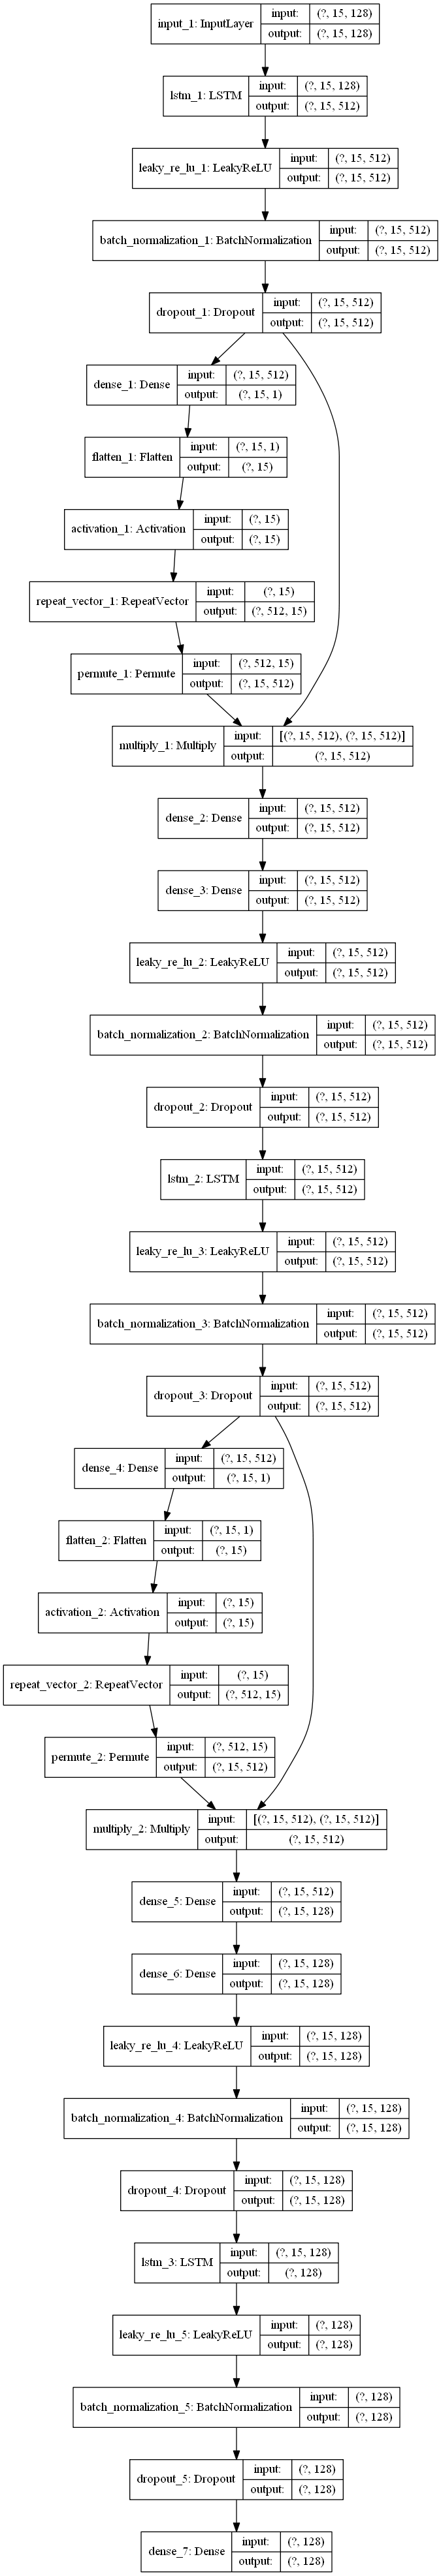

In [16]:
#show model details and create plot

model.summary()
tf.keras.utils.plot_model(
    model,
    show_shapes = True,
    expand_nested = True,
    to_file="model.png")

In [ ]:
#choose optimiser and compile
#from https://github.com/hedonistrh/bestekar/blob/master/LSTM_colab.ipynb

optimizer = keras.optimizers.Adam(lr=alpha, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.0, amsgrad=False)
# optimizer = keras.optimizers.Nadam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-8, schedule_decay=0.004)
#optimizer = keras.optimizers.SGD(lr=0.007)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [15]:
#open a previously saved full model; use this to continue training
model = keras.models.load_model('final_model_data')

In [ ]:
#train the model and produce eg. samples after every few epochs

for epoch in range(1, no_of_epochs+1): # Train model with epoch_total 
    print('Epoch:', epoch)
    model.fit(Xtrain, Ytrain, batch_size=batch_size, epochs=1,
              shuffle=True) # Fit model for 1 iteration.
        
    if ((epoch%1) == 0):
        #saves the model in case you want to continue training later and as checkpoints
        model.save_weights('epoch_' + str(epoch) + '_model_weights.h5')
        model.save('epoch_' + str(epoch) +'_model_data')

        create_samples('training_sample', model, midis_array, 'training samples', 1, 480)

In [ ]:
#save weights manually after training; use this only to generate samples

model.save_weights('final_model_weights.h5')

In [ ]:
#save the model manually in case you want to continue training later and as checkpoints
model.save('final_model_data')

In [ ]:
#to use a pre-defined or previously saved set of weights, load them with this and then generate samples below
name_h5 = ''
model.load_weights(name_h5) # load model's weights.

In [ ]:
#after training the model, take some samples :O

create_samples('produced_sample', model, midis_array, 'produced samples', 69, 420)

In [ ]:
# To see values

import bottleneck 
z = -bottleneck.partition(-preds, 20)[:20]
print (z)
print ('max:', np.max(preds))

In [10]:
bollywood_postprocess_produced_samples('produced samples', 'postprocessed samples')



postprocessing produced_sample_10_temp_0.8.mid...


postprocessing produced_sample_11_temp_2.6.mid...


postprocessing produced_sample_12_temp_2.8.mid...


postprocessing produced_sample_13_temp_1.3.mid...


postprocessing produced_sample_14_temp_0.7.mid...


postprocessing produced_sample_15_temp_0.8.mid...


postprocessing produced_sample_16_temp_3.1.mid...


postprocessing produced_sample_17_temp_2.0.mid...


postprocessing produced_sample_18_temp_1.5.mid...


postprocessing produced_sample_19_temp_2.5.mid...


postprocessing produced_sample_1_temp_1.8.mid...


postprocessing produced_sample_20_temp_3.0.mid...


postprocessing produced_sample_21_temp_0.9.mid...


postprocessing produced_sample_22_temp_0.2.mid...


postprocessing produced_sample_23_temp_0.5.mid...


postprocessing produced_sample_24_temp_1.4.mid...


postprocessing produced_sample_25_temp_3.5.mid...


postprocessing produced_sample_26_temp_3.0.mid...


postprocessing produced_sample_27_temp_0.6.mid...


postprocess